<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/langchain/langchain_Semi_Structured_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Semi-structured RAG

## [Youtube video covering this notebook](https://youtu.be/AYBMbIMG19M?si=EFv5C4BUNCWpVSNh)
[Blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)

Many documents contain a mixture of content types, including text and tables.

Semi-structured data can be challenging for conventional RAG for at least two reasons:

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search

This cookbook shows how to perform RAG on documents with semi-structured data:

* We will use [Unstructured](https://unstructured.io/) to parse both text and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables, text along with table summaries better suited for retrieval.
* We will use [LCEL](https://python.langchain.com/docs/expression_language/) to implement the chains used.

The overall flow is here:

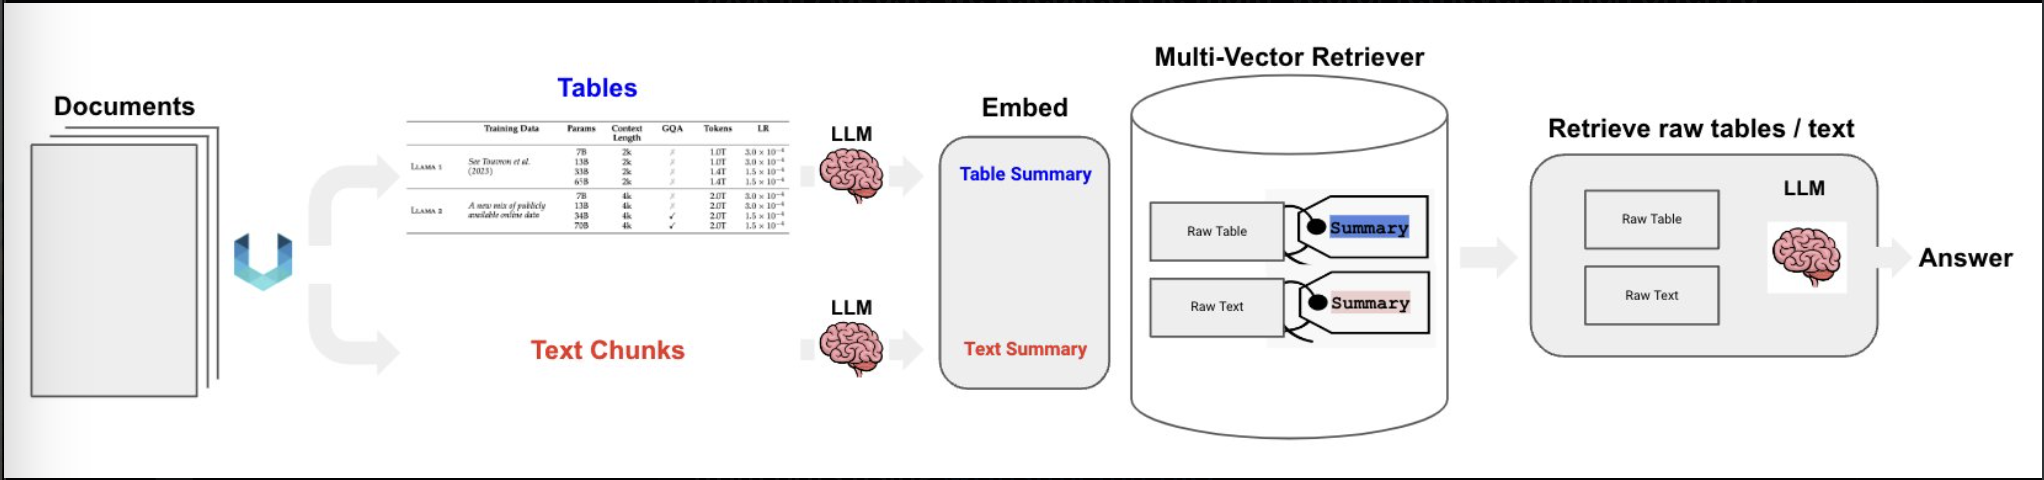

## Packages

In [ ]:
%%capture
! pip install langchain unstructured[all-docs] pydantic lxml langchainhub fastapi kaleido uvicorn

The PDF partitioning used by Unstructured will use:

* `tesseract` for Optical Character Recognition (OCR)
*  `poppler` for PDF rendering and processing

In [ ]:
#! brew install tesseract
#! brew install poppler

In [ ]:
%%capture
!sudo apt-get install poppler-utils tesseract-ocr

## Data Loading

### Partition PDF tables and text

Apply to the [`LLaMA2`](https://arxiv.org/pdf/2307.09288.pdf) paper.

We use the Unstructured [`partition_pdf`](https://unstructured-io.github.io/unstructured/bricks/partition.html#partition-pdf), which segments a PDF document by using a layout model.

This layout model makes it possible to extract elements, such as tables, from pdfs.

We also can use `Unstructured` chunking, which:

* Tries to identify document sections (e.g., Introduction, etc)
* Then, builds text blocks that maintain sections while also honoring user-defined chunk sizes

In [ ]:
import urllib.request

url = "https://arxiv.org/pdf/2307.09288.pdf"
filename = "Llama2.pdf"
urllib.request.urlretrieve(url, filename)

('Llama2.pdf', <http.client.HTTPMessage at 0x7fa585f655a0>)

In [ ]:
path = "/content/"

In [ ]:
from lxml import html
from pydantic import BaseModel
from typing import Any, Optional
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(filename=path+"Llama2.pdf",
                                 # Unstructured first finds embedded image blocks
                                 extract_images_in_pdf=False,
                                 # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
                                 # Titles are any sub-section of the document
                                 infer_table_structure=True,
                                 # Post processing to aggregate text once we have the title
                                 chunking_strategy="by_title",
                                 # Chunking params to aggregate text blocks
                                 # Attempt to create a new chunk 3800 chars
                                 # Attempt to keep chunks > 2000 chars
                                 max_characters=4000,
                                 new_after_n_chars=3800,
                                 combine_text_under_n_chars=2000,
                                 #image_output_dir_path=path
                                 )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We can examine the elements extracted by `partition_pdf`.

`CompositeElement` are aggregated chunks.

In [ ]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 120,
 "<class 'unstructured.documents.elements.Table'>": 47,
 "<class 'unstructured.documents.elements.TableChunk'>": 2}

In [ ]:
class Element(BaseModel):
    type: str
    text: Any

# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

49
120


## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to produce summaries of tables and, optionally, text.

With the summary, we will also store the raw table elements.

The summaries are used to improve the quality of retrieval, [as explained in the multi vector retriever docs](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector).

The raw tables are passed to the LLM, providing the full table context for the LLM to generate the answer.  

### Summaries

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

We create a simple summarize chain for each element.

You can also see, re-use, or modify the prompt in the Hub [here](https://smith.langchain.com/hub/rlm/multi-vector-retriever-summarization).

```
from langchain import hub
obj = hub.pull("rlm/multi-vector-retriever-summarization")
```

In [ ]:
%%capture
!pip install openai

In [ ]:
import openai
import os

# find API key in console at https://platform.openai.com/account/api-keys

os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
openai.api_key = os.environ["OPENAI_API_KEY"]

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="YOUR_LANGCHAIN_API_KEY"
os.environ["LANGCHAIN_PROJECT"]="langchain_semi_structured_RAG"

In [ ]:
# Prompt
prompt_text="""You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0,model="gpt-4")
#model = ChatOpenAI(temperature=0,model="gpt-3.5-turbo")

summarize_chain = {"element": lambda x:x} | prompt | model | StrOutputParser()

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [ ]:
# Apply to texts
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries:

* `InMemoryStore` stores the raw text, tables
* `vectorstore` stores the embedded summaries

In [ ]:
%%capture
!pip install chromadb tiktoken

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries",
    embedding_function=OpenAIEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=s,metadata={id_key: doc_ids[i]}) for i, s in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=s,metadata={id_key: table_ids[i]}) for i, s in enumerate(table_summaries)]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

## RAG from LangChain Expression Language.

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

In [ ]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = ChatOpenAI(temperature=0,model="gpt-4")
#model = ChatOpenAI(temperature=0,model="gpt-3.5-turbo")

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
chain.invoke("What is the number of training tokens for LLaMA2?")

'LLaMA 2 was pretrained on 2 trillion tokens of data from publicly available sources.'

In [ ]:
chain.invoke("What is the average tokens in prompt for Stanford SHP?")

'The average number of tokens in the prompt for Stanford SHP is 338.3.'

In [ ]:
chain.invoke("What is the average tokens in responses for Meta?")

'The average number of tokens in responses for Meta is 234.1.'

In [ ]:
# with gpt-3.5-turbo
chain.invoke("What is the average tokens in responses for Meta?")

'The average tokens in responses for Meta is 31.4.'

In [ ]:
chain.invoke("What is the Pretraining data ?")

'The pretraining data for Llama 2 models includes a new mix of data from publicly available sources, which does not include data from Meta’s products or services. Efforts were made to remove data from certain sites known to contain a high volume of personal information about private individuals. The training was performed on 2 trillion tokens of data, up-sampling the most factual sources in an effort to increase knowledge and dampen hallucinations. The pretraining data has a cutoff of September 2022.'

We can check the [trace](https://smith.langchain.com/public/7ef3c73c-7b04-4621-864d-273606657566/r) to see what chunks were retrieved.